In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import timm  # For Vision Transformer
import numpy as np

In [7]:
from ModifiedDataSets import get_cifar10_datasets
datasets = get_cifar10_datasets()

# Split into CNN and ViT datasets
cnn_datasets = {k.replace("cnn_", ""): v for k, v in datasets.items() if k.startswith("cnn_")}
vit_datasets = {k.replace("vit_", ""): v for k, v in datasets.items() if k.startswith("vit_")}

print("CNN datasets:", list(cnn_datasets.keys()))
print("ViT datasets:", list(vit_datasets.keys()))

CNN datasets: ['normal', 'gray', 'translate', 'patch', 'occluded', 'cue', 'cue_dual']
ViT datasets: ['normal', 'gray', 'translate', 'patch', 'occluded', 'cue', 'cue_dual']


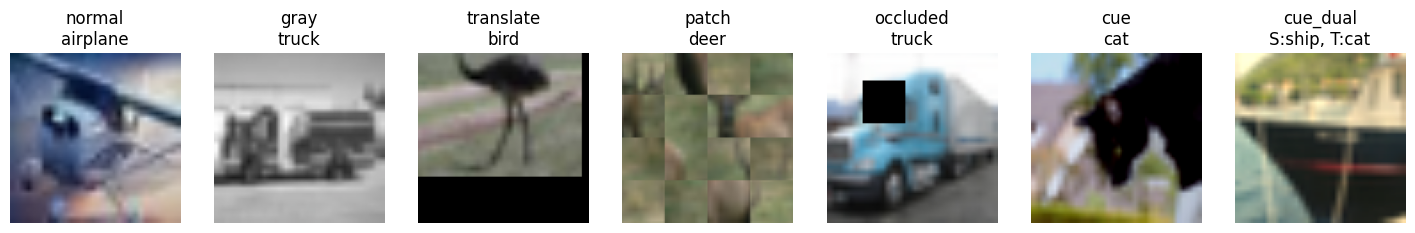

In [8]:
import random
import matplotlib.pyplot as plt

# Helper: unnormalize (to display correctly)
unnormalize = transforms.Normalize(
    mean=[-m/s for m, s in zip((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))],
    std=[1/s for s in (0.229, 0.224, 0.225)]
)

# Pick one random image from each dataset
fig, axes = plt.subplots(1, len(cnn_datasets), figsize=(18,3))
for i, (name, (train_set, test_set)) in enumerate(cnn_datasets.items()):
    idx = random.randint(0, len(test_set)-1)
    img, label = test_set[idx]

    if isinstance(label, tuple):  # dual labels
        shape_label, texture_label = label
        label_str = f"S:{test_set.classes[shape_label]}, T:{test_set.classes[texture_label]}"
    else:
        label_str = test_set.classes[label]

    img = unnormalize(img).permute(1, 2, 0).numpy().clip(0,1)
    axes[i].imshow(img)
    axes[i].set_title(f"{name}\n{label_str}")
    axes[i].axis("off")
plt.show()




In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cnn_path = "resnet50_cifar10_new.pth"
vit_path = "vit_small_cifar10_new.pth"

loaded_cnn_model = torchvision.models.resnet50(pretrained=False)
loaded_cnn_model.fc = nn.Linear(loaded_cnn_model.fc.in_features, 10)
loaded_cnn_model.to(device)

loaded_vit_model = timm.create_model("vit_small_patch16_224", pretrained=False, num_classes=10)
loaded_vit_model.to(device)

try:
    print("Loading saved models...")
    loaded_cnn_model.load_state_dict(torch.load(cnn_path, map_location=device))
    loaded_vit_model.load_state_dict(torch.load(vit_path, map_location=device))
    print("Models loaded successfully!")
except FileNotFoundError:
    print("One or more model files were not found. Please ensure they are in the correct directory.")

loaded_cnn_model.eval()
loaded_vit_model.eval()

cuda
Loading saved models...
Models loaded successfully!


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False

In [10]:
from tqdm.auto import tqdm
import torch.nn as nn

# Accuracy function
def accuracy_fn(y_true, y_pred):
    return (y_true == y_pred).sum().item() / len(y_true) * 100

# Loss function
loss_fn = nn.CrossEntropyLoss()

# Test step with tqdm
def test_step(model, data_loader, loss_fn, accuracy_fn, device=device):
    model.eval()
    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        progress_bar = tqdm(data_loader, desc="Testing", leave=False)
        for X, y in progress_bar:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)

            loss = loss_fn(y_pred, y).item()
            test_loss += loss
            acc = accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
            test_acc += acc

            progress_bar.set_postfix(loss=f"{loss:.4f}", acc=f"{acc:.2f}%")

    return test_loss / len(data_loader), test_acc / len(data_loader)

# ----------------------------
# Evaluate CNN and ViT on all datasets
# ----------------------------
results = {"CNN": {}, "ViT": {}}

# Build loaders for each test set
batch_size = 64

test_loaders_cnn = {name: DataLoader(test_set, batch_size=batch_size, shuffle=False)
                    for name, (_, test_set) in cnn_datasets.items()}

test_loaders_vit = {name: DataLoader(test_set, batch_size=batch_size, shuffle=False)
                    for name, (_, test_set) in vit_datasets.items()}

# Evaluate CNN
print("\n=== Evaluating CNN (ResNet-50) ===")
for name, loader in test_loaders_cnn.items():
    if "cue_dual" in name:   # <-- skip dual here
        continue
    loss, acc = test_step(loaded_cnn_model, loader, loss_fn, accuracy_fn, device)
    results["CNN"][name] = {"loss": loss, "acc": acc}
    print(f"{name:10s} | Loss: {loss:.4f}, Acc: {acc:.2f}%")

# Evaluate ViT
print("\n=== Evaluating ViT (ViT-S/16) ===")
for name, loader in test_loaders_vit.items():
    if "cue_dual" in name:   # <-- skip dual here
        continue
    loss, acc = test_step(loaded_vit_model, loader, loss_fn, accuracy_fn, device)
    results["ViT"][name] = {"loss": loss, "acc": acc}
    print(f"{name:10s} | Loss: {loss:.4f}, Acc: {acc:.2f}%")

# Final results dictionary
print("\n=== Summary ===")
print(results)



=== Evaluating CNN (ResNet-50) ===


normal     | Loss: 0.1943, Acc: 93.32%


gray       | Loss: 0.3842, Acc: 87.17%


translate  | Loss: 0.4619, Acc: 84.22%


patch      | Loss: 2.1230, Acc: 33.13%


occluded   | Loss: 0.4921, Acc: 83.20%


cue        | Loss: 0.3692, Acc: 87.70%

=== Evaluating ViT (ViT-S/16) ===


normal     | Loss: 0.1033, Acc: 96.60%


gray       | Loss: 0.4188, Acc: 86.74%


translate  | Loss: 0.2313, Acc: 92.62%


patch      | Loss: 1.4384, Acc: 54.57%


occluded   | Loss: 0.1255, Acc: 95.80%


cue        | Loss: 0.1771, Acc: 94.32%

=== Summary ===
{'CNN': {'normal': {'loss': 0.19428359339856038, 'acc': 93.32205414012739}, 'gray': {'loss': 0.3841600074509906, 'acc': 87.17157643312102}, 'translate': {'loss': 0.4619476567408082, 'acc': 84.2157643312102}, 'patch': {'loss': 2.1229992262117423, 'acc': 33.130971337579616}, 'occluded': {'loss': 0.4920624984297783, 'acc': 83.20063694267516}, 'cue': {'loss': 0.3691840328418525, 'acc': 87.69904458598727}}, 'ViT': {'normal': {'loss': 0.1032878852146826, 'acc': 96.59633757961784}, 'gray': {'loss': 0.41883664787005465, 'acc': 86.74363057324841}, 'translate': {'loss': 0.2312711231576599, 'acc': 92.61544585987261}, 'patch': {'loss': 1.438394262912167, 'acc': 54.56807324840764}, 'occluded': {'loss': 0.12554645611293566, 'acc': 95.80015923566879}, 'cue': {'loss': 0.1771276682662736, 'acc': 94.3172770700637}}}


In [12]:
def evaluate_shape_bias(model, dataloader, device=device):
    model.eval()
    shape_correct, texture_correct, total = 0, 0, 0

    with torch.inference_mode():
        progress_bar = tqdm(dataloader, desc="Evaluating Shape Bias", leave=False)
        for X, (y_shape, y_texture) in progress_bar:
            X, y_shape, y_texture = X.to(device), y_shape.to(device), y_texture.to(device)
            y_pred = model(X).argmax(dim=1)

            shape_correct += (y_pred == y_shape).sum().item()
            texture_correct += (y_pred == y_texture).sum().item()
            total += len(y_shape)

            progress_bar.set_postfix(
                shape_bias=f"{100*shape_correct/total:.2f}%",
                texture_bias=f"{100*texture_correct/total:.2f}%"
            )

    return 100*shape_correct/total, 100*texture_correct/total

print("\n=== Shape Bias Evaluation ===")
shape_loader_cnn = DataLoader(cnn_datasets["cue_dual"][1], batch_size=64, shuffle=False)
shape_loader_vit = DataLoader(vit_datasets["cue_dual"][1], batch_size=64, shuffle=False)

cnn_shape, cnn_texture = evaluate_shape_bias(loaded_cnn_model, shape_loader_cnn)
vit_shape, vit_texture = evaluate_shape_bias(loaded_vit_model, shape_loader_vit)

print(f"CNN Shape Bias: {cnn_shape:.2f}%, Texture Bias: {cnn_texture:.2f}%")
print(f"ViT Shape Bias: {vit_shape:.2f}%, Texture Bias: {vit_texture:.2f}%")



=== Shape Bias Evaluation ===


CNN Shape Bias: 87.91%, Texture Bias: 10.29%
ViT Shape Bias: 94.24%, Texture Bias: 10.02%


In [15]:
def evaluate_shape_bias(model, dataloader, device=device):
    model.eval()
    shape_correct, texture_correct, total = 0, 0, 0

    with torch.inference_mode():
        progress_bar = tqdm(dataloader, desc="Evaluating Shape Bias", leave=False)
        for X, (y_shape, y_texture) in progress_bar:
            X, y_shape, y_texture = X.to(device), y_shape.to(device), y_texture.to(device)
            y_pred = model(X).argmax(dim=1)

            shape_correct += (y_pred == y_shape).sum().item()
            texture_correct += (y_pred == y_texture).sum().item()
            total += len(y_shape) # 'total' is still useful to know total images

    # --- CORRECTED CALCULATION ---
    cue_aligned_predictions = shape_correct + texture_correct
    
    # Avoid division by zero if the model predicts neither shape nor texture for any image
    if cue_aligned_predictions == 0:
        shape_bias = 0.0
        texture_bias = 0.0
    else:
        shape_bias = 100 * shape_correct / cue_aligned_predictions
        texture_bias = 100 * texture_correct / cue_aligned_predictions

    print(f"Total cue-aligned predictions: {cue_aligned_predictions} out of {total} images.")
    return shape_bias, texture_bias

print("\n=== Shape Bias Evaluation ===")
shape_loader_cnn = DataLoader(cnn_datasets["cue_dual"][1], batch_size=64, shuffle=False)
shape_loader_vit = DataLoader(vit_datasets["cue_dual"][1], batch_size=64, shuffle=False)

cnn_shape, cnn_texture = evaluate_shape_bias(loaded_cnn_model, shape_loader_cnn)
vit_shape, vit_texture = evaluate_shape_bias(loaded_vit_model, shape_loader_vit)

print(f"CNN Shape Bias: {cnn_shape:.2f}%, Texture Bias: {cnn_texture:.2f}%")
print(f"ViT Shape Bias: {vit_shape:.2f}%, Texture Bias: {vit_texture:.2f}%")


=== Shape Bias Evaluation ===


Total cue-aligned predictions: 9783 out of 10000 images.


Total cue-aligned predictions: 10446 out of 10000 images.
CNN Shape Bias: 89.41%, Texture Bias: 10.59%
ViT Shape Bias: 90.22%, Texture Bias: 9.78%


Running t-SNE (CNN)...
Running t-SNE (ViT)...


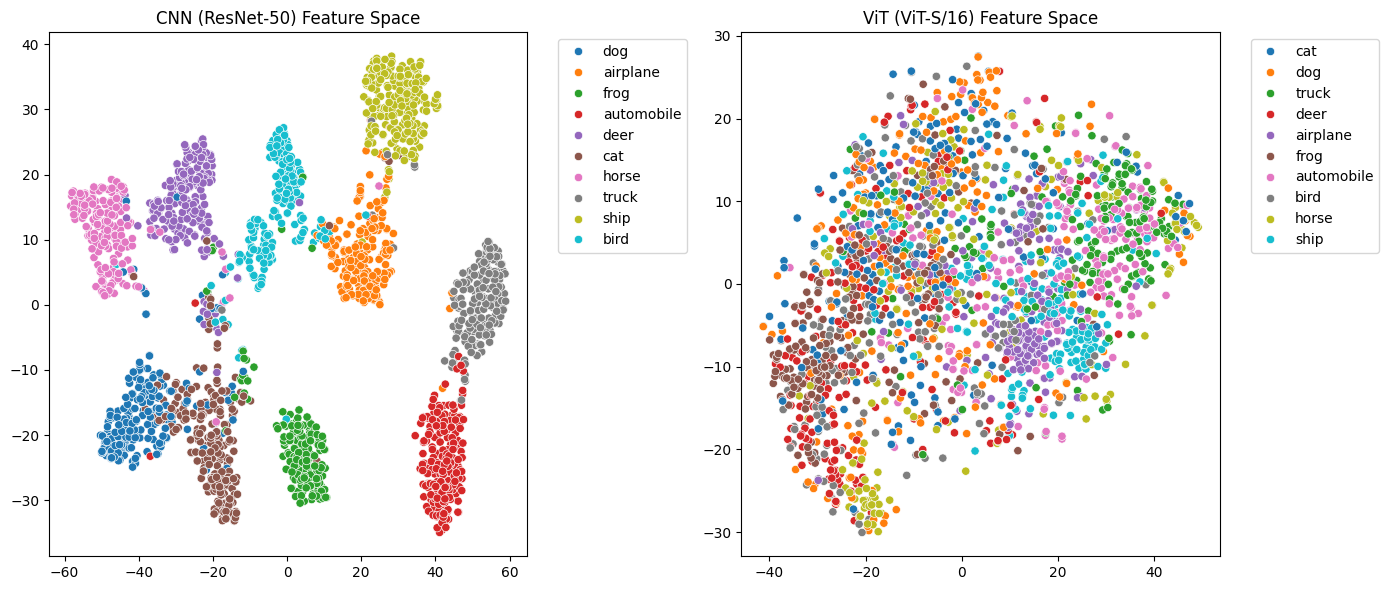

In [13]:
from sklearn.manifold import TSNE
import seaborn as sns

# CIFAR-10 class names
cifar10_classes = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

def extract_features(model, dataloader, device=device):
    """
    Extract features from penultimate layer.
    Works for ResNet (CNN) and ViT (timm).
    """
    model.eval()
    feats, labels = [], []

    # Remove classifier head
    if isinstance(model, torchvision.models.ResNet):
        feature_extractor = nn.Sequential(*list(model.children())[:-1])  # remove fc
    else:  # ViT from timm
        feature_extractor = nn.Sequential(*(list(model.children())[:-1]))

    feature_extractor.to(device)

    with torch.inference_mode():
        progress_bar = tqdm(dataloader, desc="Extracting Features", leave=False)
        for X, y in progress_bar:
            X = X.to(device)
            out = feature_extractor(X)
            out = out.view(out.size(0), -1)  # flatten
            feats.append(out.cpu())
            labels.append(y)

    feats = torch.cat(feats).numpy()
    labels = torch.cat(labels).numpy()
    return feats, labels

# Use a smaller subset for speed
subset_loader_cnn = DataLoader(cnn_datasets["normal"][1], batch_size=64, shuffle=True)
subset_loader_vit = DataLoader(vit_datasets["normal"][1], batch_size=64, shuffle=True)

# Extract features
cnn_feats, cnn_labels = extract_features(loaded_cnn_model, subset_loader_cnn)
vit_feats, vit_labels = extract_features(loaded_vit_model, subset_loader_vit)

# t-SNE (reduce to 2D)
print("Running t-SNE (CNN)...")
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
cnn_tsne = tsne.fit_transform(cnn_feats[:2000])

print("Running t-SNE (ViT)...")
vit_tsne = tsne.fit_transform(vit_feats[:2000])

# Plot CNN vs ViT
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(x=cnn_tsne[:,0], y=cnn_tsne[:,1], hue=[cifar10_classes[l] for l in cnn_labels[:2000]],
                palette="tab10", ax=axes[0])
axes[0].set_title("CNN (ResNet-50) Feature Space")
axes[0].legend(bbox_to_anchor=(1.05, 1), loc="upper left")

sns.scatterplot(x=vit_tsne[:,0], y=vit_tsne[:,1], hue=[cifar10_classes[l] for l in vit_labels[:2000]],
                palette="tab10", ax=axes[1])
axes[1].set_title("ViT (ViT-S/16) Feature Space")
axes[1].legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()
